In [1]:
import sys, os, yaml
sys.path.append('../')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from inverse_model import InverseModel
import argparse

device = torch.device('cuda:0')
plt.rcParams["font.family"] = "Times New Roman"

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
args = argparse.ArgumentParser().parse_args('')

project_dir = '../weights/case2_inverse_params_b'
config = '../config/case2_inverse_param_b.yaml'

model_dir = os.path.join(project_dir, 'best_train_loss_model.pt')

with open(config, 'r') as f:
    config = yaml.safe_load(f)
    for key, value in config.items():
        setattr(args, key, value)
        
epoch = 1000
lr = 0.1
run = 5
batch_size = 100
regl_case = 'blade_case2_free'

setattr(args, 'eval_type', 'inverse_eval')
setattr(args, 'epoch', epoch)
setattr(args, 'lr', lr)
setattr(args, 'run', run)
setattr(args,'seed', None)
setattr(args, 'bs', batch_size)
setattr(args, 'regl_case', regl_case)
setattr(args, 'project_dir', project_dir)
setattr

print(args)
evaluator = InverseModel(args)
evaluator.create_eval_dir()
evaluator.load_weights()

case_label =     ['1', '2', '3', '4', '7', '10', '5', '6', '8', '9']
case_label_dic = ['R', 'D', 'E', 'F', 'I', 'L',  'G', 'H', 'J', 'K']

Namespace(batch_size=64, bs=100, data_case='blade', decode_mode='nonlinear', depth=4, epoch=1000, eval_type='inverse_eval', id_test_dataset='../data/case2_iid_test.pkl', input_dim=200, iterative_epoch_list=None, loss_mode='NRMSE', lr=0.1, model_type='ParametricDeepONet', noised_data=False, ood_test_dataset='../data/case2_ood_test.pkl', optimizer='SGD', params_dim=200, pebasis=50, print_every=100, project_dir='../weights/case2_inverse_params_b', regl_case='blade_case2_free', run=5, save_in='../weights/case2_inverse_params_b', seed=None, solution_num=1, test_dataset=None, train_dataset='../data/case2_train.pkl', width=200)
The model is set to be:  ParametricDeepONet
The decoder mode is:  nonlinear
The depth of the model is:  4
The width of the model is:  200
Normalizing the data mode is self_min_max...
Train data is normalized by the train data...
The shape of train dataset: source_signal, params_data, response_data, ts... torch.Size([600, 1, 200]) torch.Size([600, 200]) torch.Size([600,

In [3]:
total_train_params = []
for i in range(run):
    print('train data run:', i)
    pred_train_params = evaluator.gradient_init(data=evaluator.train_data, batch_size=100, epoch=epoch, forward_net = evaluator.model, regl_case=regl_case, lr=lr, data_case = 'case2', data_source = 'train')
    total_train_params.append(pred_train_params)

mean_train_params = torch.mean(torch.stack(total_train_params), dim=0)
std_train_pred_params = torch.std(torch.stack(total_train_params), dim=0)
np.save(os.path.join(evaluator.save_dir, 'pred_mean_params_train.npy'), mean_train_params.detach().cpu().numpy())
post_pi_data = mean_train_params, evaluator.train_data[0], evaluator.train_data[1], evaluator.train_data[2], evaluator.train_data[3]
evaluator.post_pi_train_data = post_pi_data
evaluator.post_pi_train_dataset = torch.utils.data.TensorDataset(post_pi_data[0], post_pi_data[1], post_pi_data[2], post_pi_data[3], post_pi_data[4])

total_test_params = []
for i in range(run):
    print('test data run:', i)
    pred_test_params = evaluator.gradient_init(data=evaluator.test_data, batch_size=100, epoch=epoch, forward_net=evaluator.model, regl_case=regl_case, lr=lr, data_case = 'case2', data_source = 'test')
    total_test_params.append(pred_test_params)
    
mean_test_params = torch.mean(torch.stack(total_test_params), dim=0)
np.save(os.path.join(evaluator.save_dir, 'pred_mean_params_test.npy'), mean_test_params.detach().cpu().numpy())
std_test_pred_params = torch.std(torch.stack(total_test_params), dim=0)
post_pi_data = mean_test_params, evaluator.test_data[0], evaluator.test_data[1], evaluator.test_data[2], evaluator.test_data[3]
evaluator.post_pi_test_data = post_pi_data

train data run: 0
train data run: 1
train data run: 2
train data run: 3
train data run: 4
test data run: 0
test data run: 1
test data run: 2
test data run: 3
test data run: 4


In [4]:
def generate_param_vector(mu, sigma, length):
    x = torch.linspace(0, 1, length)
    y = torch.exp(-(x-mu)**2/(2*sigma**2))
    return x, y

def params_to_vector(params, length):
    batchsize = params.shape[0]
    y_sum = torch.zeros(batchsize, length)
    
    data_mu = [0.17, 0.3, 0.5]
    data_mu = torch.tensor(data_mu).to("cuda:0")
    data_mu = data_mu.repeat(batchsize, 1)

    for i in range(3):
        mu =  data_mu[:, i].unsqueeze(1) 
        high =  params[:, i].unsqueeze(1) 
        
        x, y = generate_param_vector(mu, 0.01, length)
        y = y * high
        y_sum += y
    return x, y_sum


def plot_para_gaussian(case,  mu_test, pred_mu_test, save_as = None):
    with torch.no_grad():
        fig = plt.figure(figsize=(6, 3)) 
        pred_alpha = 0.1
        alpha = 0.9
        ft = 18
        lw = 2
        
        color_pred = '#383838'
        color_true_1 = '#D4352D'
        color_true_2 = '#007afe'

        mu = mu_test[0].unsqueeze(0)
        mu_x = torch.linspace(0, 1, 200)
        mu_y = mu_test

        if case in ['1', '2', '3', '4', '7', '10']:
            plt.plot(mu_x.cpu().numpy(), mu_y[0].cpu().numpy(), '-', label = 'Training data (ground truth)', color = color_true_1, lw = lw, alpha = alpha)
            plt.plot([], [], label = 'Test data (ground truth)', color = color_true_2, lw = lw)
        else:
            plt.plot(mu_x.cpu().numpy(), mu_y[0].cpu().numpy(), '-', label = 'Ground truth, extrapolation', color = color_true_2, lw = lw, alpha = alpha)
            
        pred_mu_y = pred_mu_test
        pred_mu_x = torch.linspace(0, 1, 200)
        for i in range(pred_mu_y.shape[0]):
            
            if i == 0:
                plt.scatter(pred_mu_x.cpu().numpy(), pred_mu_y[i].cpu().numpy(), s = 5, color = color_pred, alpha = pred_alpha, label = 'Estimation')
            else:
                plt.scatter(pred_mu_x.cpu().numpy(), pred_mu_y[i].cpu().numpy(), s = 5, color = color_pred, alpha = pred_alpha)
            
        plt.title('State {}'.format(case), fontsize = 25)
        plt.xlabel('$x_{Loc}$', fontsize=ft)
        plt.ylabel('$y_{L}$', fontsize=ft, rotation=0, labelpad=20)
        plt.ylim(0, 1)
        plt.xlim(0, 1)
        plt.xticks(fontsize = ft)
        plt.yticks(fontsize = ft)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(save_as, dpi = 300)
        plt.show()
        plt.close()

Normalized RMSE of train mu:  tensor(6.0322, device='cuda:0', grad_fn=<SqrtBackward0>)
Normalized RMSE of test mu:  tensor(5.0743, device='cuda:0', grad_fn=<SqrtBackward0>)


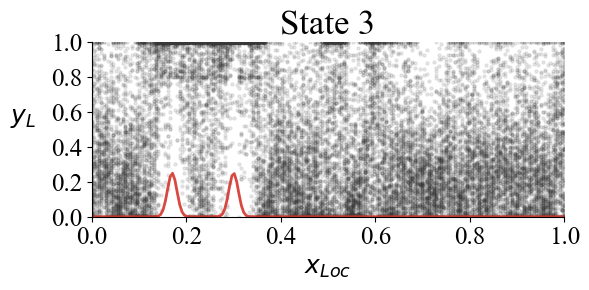

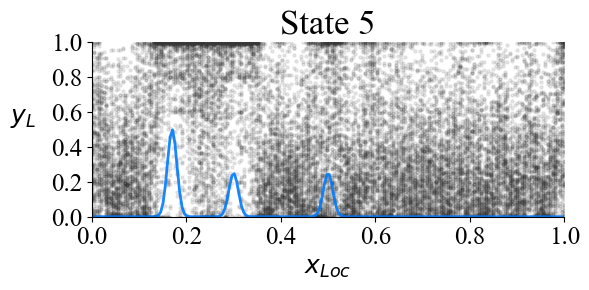

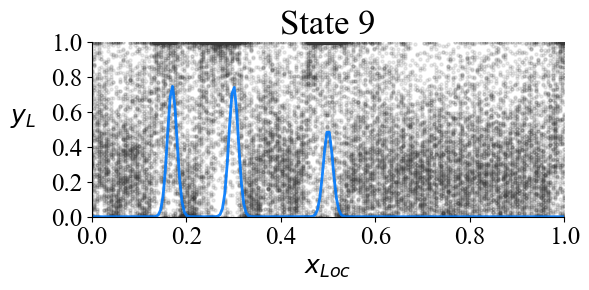

In [5]:
metrics = evaluator.evaluate_metrics(case = 'blade', mode='GI')
metrics = evaluator.evaluate_metrics(case = 'blade', mode='GI', data = 'test')
train_list = [2]
for i in train_list:
        plot_para_gaussian(case = case_label[i], mu_test = evaluator.test_data[1][100*i:100*(i+1), :], 
                        pred_mu_test= mean_test_params[100*i:100*(i+1), :], save_as =  os.path.join(evaluator.save_dir,'./gi_shape_label_{}.png'.format(case_label[i])))
        
test_list = [0, 3]
for i in test_list:
        j = i + 6
        plot_para_gaussian(case = case_label[j], mu_test = evaluator.test_data[1][100*j:100*(j+1), :],
                         pred_mu_test= mean_test_params[100*j:100*(j+1), :], save_as = os.path.join(evaluator.save_dir,'./gi_shape_label_{}.png'.format(case_label[j])))

In [6]:
import models.inverse_net
import torch.nn.functional as F

post_train_data_loader = torch.utils.data.DataLoader(evaluator.post_pi_train_dataset, batch_size=64, shuffle=True, generator=torch.Generator(evaluator.device))
    
epoch = 500
iterative_steps = 3
iter_memory = 0
lr = 0.001
run = 1

class IRNet(models.inverse_net.InitialRefineNet):
    def __init__(self):
        super(IRNet, self).__init__()
        self.gradient_nn = dde.nn.FNN([(iter_memory + 2) * 200, 512, 512, 512, 512, 512, 512, (iter_memory+1) * 200], 'relu', 'Glorot normal')

record = {}
record['train_refine_loss'], record['test_refine_loss'] = [], []
regl_case = ''
for _ in range(run):
    inverse_refine_net = IRNet()
    optimizer = torch.optim.Adam(inverse_refine_net.parameters(), lr=lr)
    scheduler = ''

    evaluator.iterative_refine(ir_net = inverse_refine_net, 
                                optimizer = optimizer,
                                forward_model = evaluator.model, 
                                data_loader= post_train_data_loader,
                                check_int = 1, epochs = epoch, iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case, data_case='case2', data_source='train', use_evaluate_mode = True)
    
    record['train_refine_loss'].append(evaluator.evaluate_record['train_refine_loss'])
    record['test_refine_loss'].append(evaluator.evaluate_record['test_refine_loss'])
np.save(os.path.join(evaluator.save_dir, 'use_forward_gradient_record.npy'), record)

In [8]:
test_mu_refine, _ = evaluator.iteratively_update_mu(forward_model = evaluator.model, ir_net= inverse_refine_net, x_t = evaluator.post_pi_test_data[1], mu_hat_0= evaluator.post_pi_test_data[0] , y_t = evaluator.post_pi_test_data[3], ts = evaluator.post_pi_test_data[4], 
                                                    iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case)
train_mu_refine, _ = evaluator.iteratively_update_mu(forward_model = evaluator.model, ir_net= inverse_refine_net, x_t = evaluator.post_pi_train_data[1], mu_hat_0= evaluator.post_pi_train_data[0] , y_t = evaluator.post_pi_train_data[3], ts = evaluator.post_pi_train_data[4], 
                                                     iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case)

Normalized RMSE of train mu:  tensor(0.1129, device='cuda:0', grad_fn=<SqrtBackward0>)
Normalized RMSE of test mu:  tensor(0.7751, device='cuda:0', grad_fn=<SqrtBackward0>)


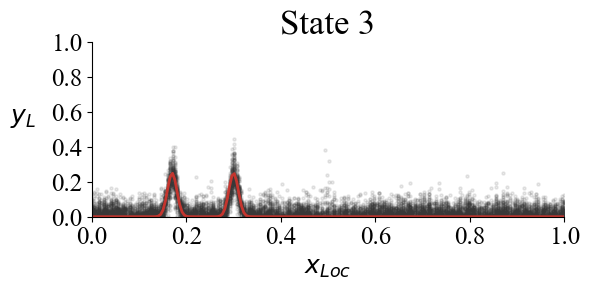

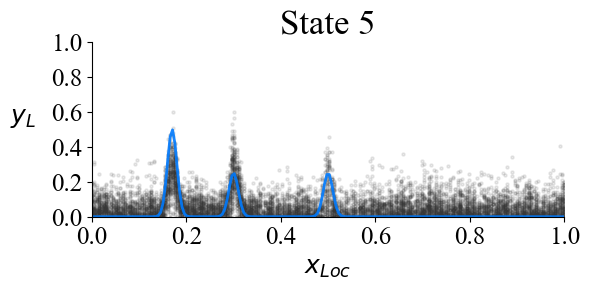

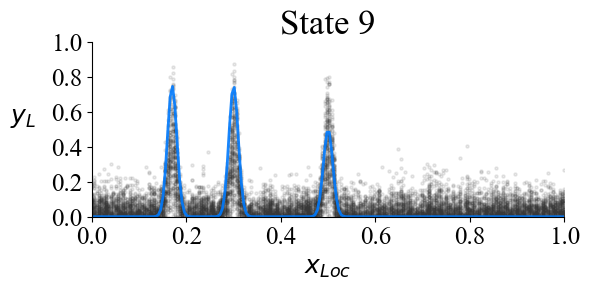

In [9]:
metrics = evaluator.evaluate_metrics(case = 'blade', mode='NR')
metrics = evaluator.evaluate_metrics(case = 'blade', mode='NR', data = 'test')
train_list = [2]
for i in train_list:
        plot_para_gaussian(case = case_label[i], mu_test = evaluator.test_data[1][100*i:100*(i+1), :],
                         pred_mu_test= test_mu_refine[100*i:100*(i+1), :], save_as =  os.path.join(evaluator.save_dir,'./nr_shape_label_{}.png'.format(case_label[i])))
        
test_list = [0, 3]
for i in test_list:
        j = i + 6
        plot_para_gaussian(case = case_label[j], mu_test = evaluator.test_data[1][100*j:100*(j+1), :],
                         pred_mu_test= test_mu_refine[100*j:100*(j+1), :], save_as = os.path.join(evaluator.save_dir,'./nr_shape_label_{}.png'.format(case_label[j])))